<a href="https://colab.research.google.com/github/alecbidaran/Deep-learning/blob/main/HAR_GRU_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling3D, Activation, UpSampling2D, BatchNormalization, add, concatenate, Lambda, Flatten, Conv2DTranspose,DepthwiseConv2D,ConvLSTM2D,TimeDistributed,Dropout
from tensorflow.keras.optimizers import RMSprop,Adam
import tensorflow.keras as keras 
import tensorflow as tf
import numpy as np 
import cv2 
import os 
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [141]:
!git clone https://github.com/bartkowiaktomasz/har-wisdm-lstm-rnns.git

fatal: destination path 'har-wisdm-lstm-rnns' already exists and is not an empty directory.


In [142]:
import pandas as pd 
from scipy.io import arff
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]
LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]
dataset=pd.read_csv("/content/har-wisdm-lstm-rnns/data/WISDM_ar_v1.1_raw.txt",header=None,names=COLUMN_NAMES )


In [143]:
dataset['z-axis'].replace(to_replace=r';',value=r'',regex=True,inplace=True)
dataset['z-axis'] = dataset['z-axis'].astype('float')
dataset.dropna(axis=0, how='any', inplace=True)
dataset.sample(100)

,user,activity,timestamp,x-axis,y-axis,z-axis
1046704,7,Upstairs,209041271638000,-7.12,1.88,-1.330000
281885,32,Walking,23446093459000,-0.53,13.21,0.721878
652624,23,Walking,354192302000,-2.03,13.59,-7.500000
457874,35,Sitting,155862315000,4.71,7.12,5.560000
955072,1,Walking,5733572339000,-7.89,13.21,-0.760000
...,...,...,...,...,...,...
146791,15,Jogging,927332286000,18.81,-0.80,4.753501
988415,2,Walking,8119752424000,-4.52,13.14,-1.950000
577996,20,Sitting,59067202282000,-3.02,3.11,9.080000
358902,16,Walking,5429032298000,17.16,-0.89,3.405087


In [144]:
dataset[['timestamp','x-axis','y-axis','z-axis','activity']]


,timestamp,x-axis,y-axis,z-axis,activity
0,49105962326000,-0.694638,12.680544,0.503953,Jogging
1,49106062271000,5.012288,11.264028,0.953424,Jogging
2,49106112167000,4.903325,10.882658,-0.081722,Jogging
3,49106222305000,-0.612916,18.496431,3.023717,Jogging
4,49106332290000,-1.184970,12.108489,7.205164,Jogging
...,...,...,...,...,...
1098199,131623331483000,9.000000,-1.570000,1.690000,Sitting
1098200,131623371431000,9.040000,-1.460000,1.730000,Sitting
1098201,131623411592000,9.080000,-1.380000,1.690000,Sitting
1098202,131623491487000,9.000000,-1.460000,1.730000,Sitting


In [145]:
enc = LabelEncoder()
labeled=enc.fit_transform(dataset.loc[:,('activity')].ravel())
dataset['labeled_activites']=labeled
dataset

,user,activity,timestamp,x-axis,y-axis,z-axis,labeled_activites
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


In [146]:
mag=np.sqrt(dataset['x-axis']**2+dataset['y-axis']**2+dataset['z-axis']**2)
dataset['magnitude']=mag
dataset

,user,activity,timestamp,x-axis,y-axis,z-axis,labeled_activites,magnitude
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1,12.709551
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1,12.365693
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1,11.936562
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1,18.751973
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1,14.139804
...,...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2,9.290910
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2,9.319125
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2,9.338463
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2,9.280329


In [147]:
train=dataset[dataset['user']<=28]
test=dataset[dataset['user']>28]
train

,user,activity,timestamp,x-axis,y-axis,z-axis,labeled_activites,magnitude
8489,17,Walking,57869902574000,0.572055,9.806650,-0.531194,5,9.837672
8490,17,Walking,57870012316000,-0.000000,10.188020,-0.572055,5,10.204068
8491,17,Walking,57870122301000,-0.231546,9.847511,-0.694638,5,9.874695
8492,17,Walking,57870222246000,0.149824,10.079058,-0.503953,5,10.092761
8493,17,Walking,57870332292000,0.149824,10.147159,-0.612916,5,10.166757
...,...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2,9.290910
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2,9.319125
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2,9.338463
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2,9.280329


In [148]:
def sliding_window(dataframe,time_steps,steps):
  xs=[]
  ys=[]
  for i in range(0,len(dataframe)-time_steps,steps):
    ext_step=i+time_steps
    if ext_step>len(dataframe)-1:
      break
    xi=dataframe['x-axis'].values[i:i+time_steps]
    y1=dataframe['y-axis'].values[i:i+time_steps]
    z1=dataframe['z-axis'].values[i:i+time_steps]
    yi=stats.mode(dataframe['labeled_activites'][i:i+time_steps])[0][0]
    xs.append([xi,y1,z1])
    ys.append(yi)
  return np.asarray(xs),np.asarray(ys)

In [149]:
x_train,y_train=sliding_window(train,90,50)
x_test,y_test=sliding_window(test,90,50)

In [150]:
x_train.shape

(16694, 3, 90)

In [151]:
x_train=x_train.reshape(-1,90,3).astype(np.float32)
x_test=x_test.reshape(-1,90,3).astype(np.float32)

In [152]:
x_train=(x_train-x_train.mean())/x_train.std()
x_test=(x_test-x_test.mean())/x_test.std()

In [171]:
def create_model():
  model=keras.models.Sequential([tf.keras.layers.Input(shape=[90,3]),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv1D(32,3,strides=2,padding="same"),
      tf.keras.layers.MaxPool1D(),
      tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Conv1D(64,3,strides=1,padding="same"),
      tf.keras.layers.MaxPool1D(),
      tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Conv1D(128,3,strides=1,padding="same"),
      tf.keras.layers.MaxPool1D(),
    tf.keras.layers.GRU(128,return_sequences=True,recurrent_dropout=0.2),
    tf.keras.layers.GRU(128,return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6,activation="softmax")

                               ])
  return model

In [176]:
disturbution=tf.distribute.experimental.CentralStorageStrategy()
with disturbution.scope():
  model=create_model()
  model.summary()
  model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
  

INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:GPU:0'], variable_device = '/job:localhost/replica:0/task:0/device:GPU:0'
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_76 (Batc (None, 90, 3)             12        
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 45, 32)            320       
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 22, 32)            0         
_________________________________________________________________
batch_normalization_77 (Batc (None, 22, 32)            128       
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 22, 64)            6208      
______________

In [177]:
Y_train=keras.utils.to_categorical(y_train,num_classes=6)
Y_test=keras.utils.to_categorical(y_test,num_classes=6)

In [178]:
checkpoint=keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=1, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

reduce_LOP=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.01, cooldown=0, min_lr=0.001)
Callbacks=[checkpoint,reduce_LOP]


In [179]:
history=model.fit(x_train,Y_train,batch_size=16,epochs=10,verbose=1,validation_data=(x_test,Y_test),callbacks=Callbacks)

Epoch 1/10
1044/1044 [==============================] - 33s 26ms/step - loss: 0.6687 - accuracy: 0.7687 - val_loss: 0.5594 - val_accuracy: 0.8096
Epoch 2/10
1044/1044 [==============================] - 25s 24ms/step - loss: 0.4419 - accuracy: 0.8398 - val_loss: 0.5302 - val_accuracy: 0.8215
Epoch 3/10
1044/1044 [==============================] - 26s 24ms/step - loss: 0.3591 - accuracy: 0.8689 - val_loss: 0.4901 - val_accuracy: 0.8477
Epoch 4/10
1044/1044 [==============================] - 25s 24ms/step - loss: 0.3055 - accuracy: 0.8921 - val_loss: 0.5052 - val_accuracy: 0.8532
Epoch 5/10
1044/1044 [==============================] - 25s 24ms/step - loss: 0.2600 - accuracy: 0.9078 - val_loss: 0.4720 - val_accuracy: 0.8625
Epoch 6/10
1044/1044 [==============================] - 25s 24ms/step - loss: 0.2247 - accuracy: 0.9217 - val_loss: 0.5084 - val_accuracy: 0.8610
Epoch 7/10
1044/1044 [==============================] - 26s 25ms/step - loss: 0.2032 - accuracy: 0.9293 - val_loss: 0.4779 -

In [180]:
import matplotlib.pyplot as plt


Text(0, 0.5, 'accuracy')

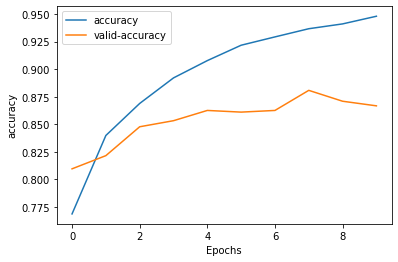

In [181]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='valid-accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("accuracy")

Text(0, 0.5, 'Loss')

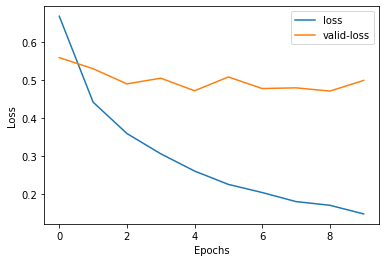

In [182]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='valid-loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [183]:
pred_test=model.predict(x_test)
pred_test

array([[3.29944380e-02, 9.66323197e-01, 1.35692419e-04, 3.59637081e-04,
        1.57457296e-04, 2.96751532e-05],
       [1.20557542e-03, 9.97926593e-01, 2.55652441e-04, 9.73842252e-05,
        4.66442580e-04, 4.83344120e-05],
       [6.85845211e-04, 9.98600185e-01, 1.09489578e-04, 1.20296769e-04,
        3.74156458e-04, 1.10166402e-04],
       ...,
       [1.34842383e-04, 1.53600425e-03, 9.35878754e-01, 5.74331805e-02,
        3.93484160e-03, 1.08234724e-03],
       [1.12789436e-04, 1.01999938e-03, 9.44047213e-01, 5.23280092e-02,
        1.66042917e-03, 8.31572746e-04],
       [1.32976013e-04, 1.40676880e-03, 9.34796929e-01, 5.93063906e-02,
        3.17802746e-03, 1.17889279e-03]], dtype=float32)

In [184]:
Y_test

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [185]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
import seaborn as sns

In [186]:
y_pred_test=np.argmax(pred_test,axis=1)
print(y_pred_test)
print(y_test)

[1 1 1 ... 2 2 2]
[1 1 1 ... 3 3 3]


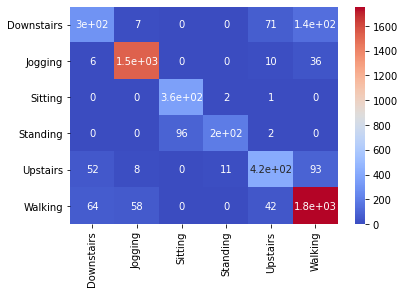

In [187]:
confusion_matrix=metrics.confusion_matrix(y_test,y_pred_test)
sns.heatmap(confusion_matrix,cmap='coolwarm',linecolor='white',xticklabels=LABELS,yticklabels=LABELS,annot=True)

In [188]:
print(classification_report(y_test,y_pred_test,target_names=LABELS))

              precision    recall  f1-score   support

  Downstairs       0.71      0.58      0.64       521
     Jogging       0.95      0.97      0.96      1588
     Sitting       0.79      0.99      0.88       362
    Standing       0.94      0.67      0.78       296
    Upstairs       0.77      0.72      0.74       580
     Walking       0.87      0.91      0.89      1920

    accuracy                           0.87      5267
   macro avg       0.84      0.81      0.81      5267
weighted avg       0.87      0.87      0.86      5267

